# Transfer learning with Tensorflow 2.0
Simple example that loads a mobile-v2 pre-trained with imageNet and retrain with fewer images.

Installing dependencies
```bash
pip install tensorflow==2.0.0-alpha0 
pip install tensorflow_datasets
```

#### Things you will learn here:
1. Use Transfer learning with Keras and MobileNet
2. Use Keras with Tensorboard
3. Fine Tune
4. Convert keras model to Tensorflow-lite

### References
* https://www.tensorflow.org/alpha/tutorials/images/transfer_learning
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://www.tensorflow.org/guide/datasets
* https://www.youtube.com/watch?v=2U6Jl7oqRkM
* https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
* https://medium.com/ymedialabs-innovation/how-to-use-dataset-and-iterators-in-tensorflow-with-code-samples-3bb98b6b74ab
* https://www.tensorflow.org/lite/guide/get_started
* https://www.tensorflow.org/lite/convert
* https://speakerdeck.com/margaretmz/tf-dot-keras-to-tensorflow-lite-for-android?slide=38
* https://www.youtube.com/watch?v=MZx1fhbL2q4
* https://www.youtube.com/watch?v=ICY4Lvhyobk
* https://www.youtube.com/watch?v=DKosV_-4pdQ
* https://www.youtube.com/watch?v=JnhW5tQ_7Vo
* https://www.youtube.com/watch?v=RhjBDxpAOIc
* https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter
* https://www.tensorflow.org/lite/convert/python_api
* https://www.tensorflow.org/lite/r2/convert/python_api

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
keras = tf.keras
print('Tensorflow version:',tf.__version__)
import tensorflow_datasets as tfds

IMG_SIZE = 160 # All images will be resized to 160x160
BATCH_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
EPOCHS = 10
base_learning_rate = 0.0001
num_classes=1

Tensorflow version: 2.0.0-alpha0


### Get the data

In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip", 
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

#### Separate data into train and validation

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Create Generator and Process Data

In [4]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(IMG_SIZE, IMG_SIZE),  
                batch_size=BATCH_SIZE,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
# Make the whole mobilenet a feature extractor
base_model.trainable = False

# Display a summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Create a model with base_model and few layers

In [6]:
# Base model as feature extraction
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(), # Auto-calculate a pooling that converts to vector
  keras.layers.Dense(num_classes, activation='sigmoid')
])


# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


# Let's take a look to see how many layers are in the base model
print("Number of layers in the complete model: ", len(model.layers))

Number of layers in the base model:  155
Number of layers in the complete model:  3


### Create the Model
The Keras compilation phase just create the model graph (Initialize parameters, etc....). You need to pass the following information:
* Loss function
* Metrics for inspect accuracy
* Optimizer

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Prepare Tensorboard
This step will get a directory name and create a tensorboard callback to be passed to the keras fit method.
Running Tensorboard: (From notebooks directory)
```bash
tensorboard --logdir=logs/scalars/
```

In [8]:
logdir="logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

### Train Model
Here we just call the .fit method from the keras compiled model.

In [9]:
steps_per_epoch = train_generator.n // BATCH_SIZE
validation_steps = validation_generator.n // BATCH_SIZE
print('Steps per Epoch:(Train)', steps_per_epoch)
print('Steps per Epoch:(Validation)', validation_steps)
history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=EPOCHS, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps,
                             callbacks=[tensorboard_callback])

Epoch 1/10
62/62 [==============================] - 45s 732ms/step - loss: 0.7306 - accuracy: 0.5462 - val_loss: 0.6563 - val_accuracy: 0.6058
Epoch 2/10
62/62 [==============================] - 42s 685ms/step - loss: 0.5781 - accuracy: 0.6987 - val_loss: 0.4767 - val_accuracy: 0.8155
Epoch 3/10
62/62 [==============================] - 42s 678ms/step - loss: 0.4704 - accuracy: 0.7901 - val_loss: 0.3695 - val_accuracy: 0.8770
Epoch 4/10
62/62 [==============================] - 42s 677ms/step - loss: 0.3972 - accuracy: 0.8548 - val_loss: 0.3015 - val_accuracy: 0.9062
Epoch 5/10
62/62 [==============================] - 38s 609ms/step - loss: 0.3502 - accuracy: 0.8765 - val_loss: 0.2628 - val_accuracy: 0.9173
Epoch 6/10
62/62 [==============================] - 42s 675ms/step - loss: 0.3145 - accuracy: 0.8902 - val_loss: 0.2304 - val_accuracy: 0.9274
Epoch 7/10
62/62 [==============================] - 42s 677ms/step - loss: 0.2912 - accuracy: 0.8979 - val_loss: 0.2117 - val_accuracy: 0.9304

### Plot Curves

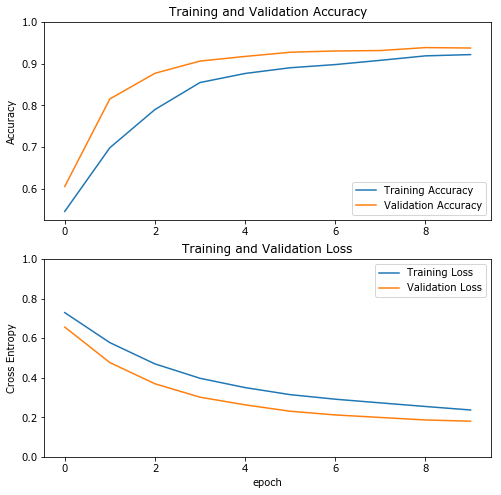

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tune Models
If you have enough data to consume the mobilenet layers you can let few of it's layers to be trained.

In [11]:
# Unfreeze MobileNet
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


#### Train Fine tune

In [14]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=EPOCHS, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 68s 1s/step - loss: 0.1895 - accuracy: 0.9360 - val_loss: 0.1181 - val_accuracy: 0.9597
Epoch 2/10
62/62 [==============================] - 59s 950ms/step - loss: 0.1350 - accuracy: 0.9573 - val_loss: 0.0982 - val_accuracy: 0.9637
Epoch 3/10
62/62 [==============================] - 59s 945ms/step - loss: 0.1069 - accuracy: 0.9695 - val_loss: 0.0880 - val_accuracy: 0.9667
Epoch 4/10
62/62 [==============================] - 59s 954ms/step - loss: 0.0777 - accuracy: 0.9788 - val_loss: 0.0823 - val_accuracy: 0.9677
Epoch 5/10
62/62 [==============================] - 59s 946ms/step - loss: 0.0729 - accuracy: 0.9800 - val_loss: 0.0777 - val_accuracy: 0.9708
Epoch 6/10
62/62 [==============================] - 59s 957ms/step - loss: 0.0518 - accuracy: 0.9868 - val_loss: 0.0757 - val_accuracy: 0.9708
Epoch 7/10
62/62 [==============================] - 58s 932ms/step - loss: 0.0470 - accuracy: 0.9893 - val_loss: 0.0742 - val_accuracy: 0.9748
Ep

### Plot Fine-Tune Curves

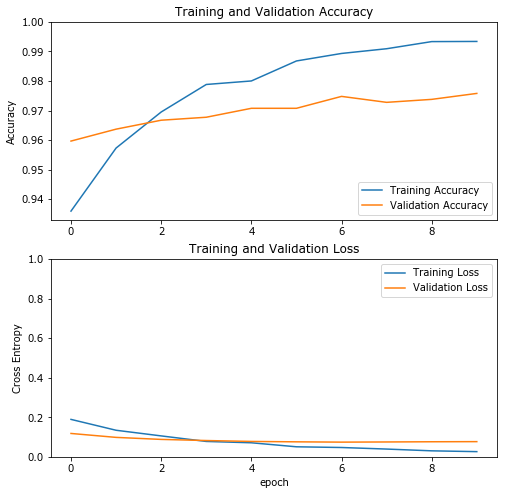

In [15]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Convert Model to Tensorflow Lite

In [23]:
# Save model (Not needed anymore)
keras_model_file='model_transfer_mbnet.h5'
keras.models.save_model(model, keras_model_file)

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model(x))
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([None, 160, 160, 3], tf.float32))

# Convert the model.
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()

W0402 20:26:29.394511 4673156544 meta_graph.py:447] Issue encountered when serializing global_step.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


KeyError: 'sequential/mobilenetv2_1.00_160/bn_Conv1/FusedBatchNorm/ReadVariableOp/resource'

In [24]:
import numpy as np
import tensorflow as tf

# Load the MobileNet tf.keras model.
model = tf.keras.applications.MobileNetV2(
    weights="imagenet", input_shape=(224, 224, 3))

# Save and load the model to generate the concrete function to export.
export_dir = "/tmp/test_model/mobilenet"
tf.saved_model.save(model, export_dir)
model = tf.saved_model.load(export_dir)
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

# Set the shape manually.
concrete_func.inputs[0].set_shape([1, 224, 224, 3])

# Convert the model.
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

14540800/14536120 [==============================] - 1s 0us/step


W0402 20:29:29.674714 4673156544 meta_graph.py:447] Issue encountered when serializing global_step.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
W0402 20:29:30.009918 4673156544 meta_graph.py:447] Issue encountered when serializing global_step.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


[[9.07237427e-06 2.09588306e-05 9.92991845e-05 1.14852308e-04
  1.44104275e-03 2.34968655e-04 8.72794306e-04 1.25977140e-05
  5.65392929e-06 5.05771095e-06 2.62308504e-06 2.45786350e-06
  2.49232744e-06 1.62000997e-05 8.90737938e-05 9.33171577e-06
  1.21965304e-05 4.40482199e-06 2.28686495e-05 3.15226521e-06
  5.84000054e-06 2.23941083e-06 3.82584813e-06 9.47091576e-06
  1.01870364e-05 8.47757110e-06 3.77177116e-06 1.49199486e-05
  4.55903637e-06 1.41618711e-05 1.77867641e-05 9.45747706e-06
  1.67005874e-06 2.99730200e-05 2.66760908e-04 6.57932787e-06
  8.53732581e-06 6.49167123e-06 1.70332100e-06 4.75025990e-06
  6.82972313e-06 4.92820573e-06 9.43568466e-06 4.59258990e-06
  7.93849267e-06 6.24136646e-06 2.81218909e-05 2.30547676e-06
  7.24910351e-05 1.47191631e-05 6.89406006e-05 1.01619335e-05
  2.00461341e-06 1.40029613e-06 8.03714192e-06 1.47828678e-06
  2.12849955e-06 9.96002996e-07 4.24009750e-06 2.47280946e-06
  1.73383687e-05 7.65692967e-05 9.57115753e-06 1.73245587e-06
  4.1215